# Grover's Algorithm

### Three Components
1. Create superposition of 2<sup>n</sup> basis states: 
    * How? apply (H) gate on each qubit 
    * each qubit in state: $\vert0\rangle^{\otimes n}$ 
    * $\otimes n$ means a tensor product of states of n qubits
2. Apply an Oracle operator
    * Oracle operator? applies coefficient -1 to each marked element
    * Why? Allows us to single out elements that we want to know the probability distribution for
3. Apply a Diffusion operator
    * inverts amplitude of all elements 
    * in relation to average overall amplitude

Then: 
1. Put all the components together
2. Apply Oracle and Diffusion operators $O(\sqrt{N = 2^n}))$ times

What does Grover's algorithm do? 
* determines probability of elements marked by Oracle operator

### AIM
1. Implement Grovers algorithm with a quantum circuit
2. Mark elements $000001$ and $101010$ 
3. Determine the probilities of those elements with high probability

In [1]:
%pip install -U -r resources/requirements.txt

from IPython.display import clear_output
clear_output()

## Phase Oracle Guidelines

1. add phase of -1 to all marked elements
2. create identity matrix $2^n$ 
3. change diagonal elements to -1 for desired elements
4. convert unitary matrix --> operator

In [156]:
# PHASE ORACLE
from qiskit.quantum_info import Operator
from qiskit import QuantumCircuit
import numpy as np

# first arg: (n) gives number of qubits in circuit 
# second arg: (indices_to_mark) indices of elements that will be marked -1

# AIM: mark elements of 2^n x 2^n identity matrix 
# DISCLAIMER: I didn't know about np.identity

# ORIGINAL ATTEMPT (doesn't work) 
# def createMatrix(n, indices_to_mark):
#     matrix = []
#     for x in range (2**n): # each row
#         matrix.append([])
#         for y in range (2**n): # each item in row x 
#             matrix[x].append(0)
#     for index in indices_to_mark: # each item in indices_to_mark
#         for i in range (2**n): # each row
#             if (index >= i*(2**n - 1) and i <= (i+1)*(2**n - 1) and 
#             (index % (2**n - 1)) != 0):
#                 currentRowIndex = index % (2**n)
#                 matrix[i][currentRowIndex] = -1
#             elif (index % (2**n - 1) == 0 and index != 0): 
#                 matrix[i][3] = -1
#             elif (index == 0):
#                 matrix[i][0] = -1
#     return matrix
# print(createMatrix(2, [1, 4]))

# TEST FUNCTION
def createMatrix(n, indices_to_mark):
    matrix = []
    for x in range (2**n): # each row
        matrix.append([])
        for y in range (2**n): # each item in row x 
            if (y == x): 
                matrix[x].append(1)
            else: 
                matrix[x].append(0)

    # OPTIMAL SOLUTION
    for index in indices_to_mark: 
        # let index = 11
        row = index // (2**n) # 11 / 4 = 2 --> like floor 
        col = index % (2**n) # 11 % 4 = 3
        matrix[row][col] = -1
    return matrix
# print(createMatrix(2, [1, 5]))

    # NAIVE APPROACH
    # flattened = []
    # for row in matrix: 
    #     for x in row: 
    #         flattened.append(x)
    # for index in indices_to_mark: 
    #     flattened[index] = -1

    # newMatrix = np.reshape(flattened, (2**n, 2**n))
    # return newMatrix
# print(createMatrix(2, [1, 3, 4]))

# QUANTUM FUNCTION
def phase_oracle(n, indices_to_mark, name = "Oracle"): 
    # qc = QuantumCircuit(n, name=name)
    # # create 2^n x 2^n oracle matrix
    # # set elements at indices_to_mark to -1, others to 0

    # MY/PRESTON'S SOLUTION --> returns size error during implementation
    
    # oracle_matrix = []
    # for x in range (2**n): # each row
    #     oracle_matrix.append([])
    #     for y in range (2**n): # each item in row x 
    #         if (y == x): 
    #             oracle_matrix[x].append(1)
    #         else: 
    #             oracle_matrix[x].append(0)
    # for index in indices_to_mark: 
    #     row = index // (2**n)
    #     col = index % (2**n)
    #     oracle_matrix[row][col] = -1
    # # return oracle_matrix; 
    # qc.unitary(Operator(oracle_matrix), range(n))

    # OFFICIAL SOLUTION 
    
    qc = QuantumCircuit(n, name=name)
    oracle_matrix = np.identity(2**n)
    for index_to_mark in indices_to_mark:
        oracle_matrix[index_to_mark, index_to_mark] = -1 # np row, col
    qc.unitary(Operator(oracle_matrix), range(n))
    return qc

# Diffusion Operator

* create a circuit with a Hadamard gate on each qubit
* sandwich the phase_oracle operator in the circuit between another Hadamard gate on each qubit

This will invert the amplitude of all the qubits in relation to their average amplitude. 


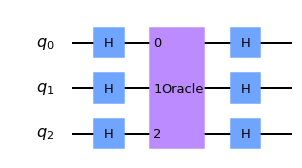

In [157]:
def diffuser(n): 
    circuit = QuantumCircuit(n, name="Diffuser")
    circuit.h(range(n)) # add hadamard on each qubit
    circuit.append(phase_oracle(n, [0]), range(n)) # create 
    circuit.h(range(n)) # add hadamard on each qubit
    return circuit

# test with 3^3
diffuser(3).draw("mpl")

# Grover's Algorithm



6 qubits, basis states [1, 42] marked, 4 rounds


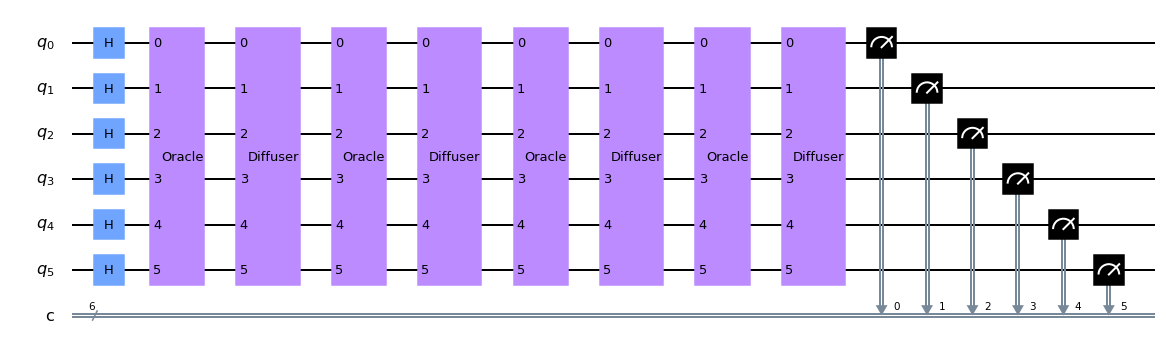

In [158]:
def Grover(n, indices_of_marked_elements):
    
    # Create a quantum circuit on n qubits
    qc = QuantumCircuit(n, n)
    
    # Determine r
    r = int(np.floor(np.pi/4*np.sqrt(2**n/len(indices_of_marked_elements))))
    print(f'{n} qubits, basis states {indices_of_marked_elements} marked, {r} rounds')
    
    # step 1: apply Hadamard gates on all qubits
    qc.h(range(n))
    
    # step 2: apply r rounds of the phase oracle and the diffuser
    for _ in range(r):
        qc.append(phase_oracle(n, indices_of_marked_elements), range(n))
        qc.append(diffuser(n), range(n))
        
    # step 3: measure all qubits
    qc.measure(range(n), range(n))
  
    return qc

mycircuit = Grover(6, [1, 42])
mycircuit.draw("mpl")

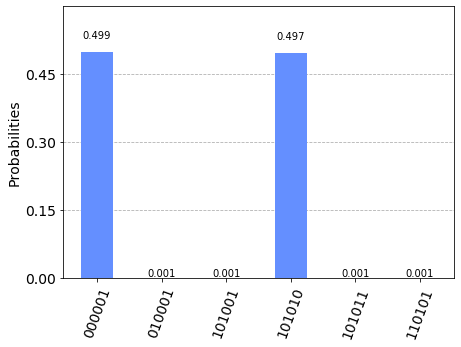

In [159]:
from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')
counts = execute(mycircuit, backend=simulator, shots=1000).result().get_counts(mycircuit)
from qiskit.visualization import plot_histogram
plot_histogram(counts)